# Impact of Scientific Misconduct
This notebook produces "napkin math" estimates of the number of QALYs ([Quality Adjusted Life Years](https://en.wikipedia.org/wiki/Quality-adjusted_life_year)) caused by the delayed launch of effective treatments for Alzheimers disease and cancer.

### General Assumptions
* In the absence of new treatments, there is a fixed number of people with the disease, maintained by a constant stream of disease onsets and deaths. 
* QOL (Quality of Life) declines linearly from disease onset (quality=1) to death (quality=0)
* The treatment reduces the slope of this decline.

Disease-specific assumptions are described below.

### Main findings
* Assuming that the Alzheimer's duration is 10 years, and that an effective treatment would slow down QOL decline by a factor of 2, a one year delay in the launch of an effective treatment would cost **36 million QALYs**.
* Assuming that the cancer duration is 3 years, and that an effective treatment would slow down QOL decline by a factor of 3, a one year delay in the launch of an effective treatment would cost **15 million QALYs**.

Obviously the assumptions in this notebook could be disputed, but if we accept that the delay is 1 year and mostly accept the assumptions about disease progression with and without treatment, I suspect my conclusions are accurate within a factor of 2.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from datetime import date

In [2]:
%config InlineBackend.figure_format='retina'

In [3]:
blue='#3ac3f2'
gray='#aaaaaa'

In [14]:
@dataclass
class Simulation:
    pre_cure_disease_duration: int # in months
    post_cure_disease_duration: int # in months
    cure_onset: int = 24 # in months
    num_persons: int = 8 # assumes one per year
    onset_freq: int = 'M'
    max_year: int = 2046
    
    def __post_init__(self):
        self.dates = pd.date_range(pd.Timestamp(2030,1,1), pd.Timestamp(self.max_year,1,1), freq='M')
        self.sim_duration = len(self.dates)
        if self.onset_freq == 'M':
            self.disease_onsets = np.arange(0, self.num_persons, 1)
        elif self.onset_freq == 'Y':
            self.disease_onsets = np.arange(0, self.num_persons*12, 12)

        self.n = len(self.disease_onsets)
            
    
    def get_disease_time_pre_cure(self, t: int, disease_onset: int):
        if t <= disease_onset or self.cure_onset < disease_onset:
            return 0
        elif t <= self.cure_onset:
            return t - disease_onset
        else: 
            return self.cure_onset - disease_onset
    
    def get_disease_time_post_cure(self, t: int , disease_onset: int):
        if t <= disease_onset or t <= self.cure_onset:
            return 0
        else:
            return t - max(disease_onset, self.cure_onset)
    
    def get_qol(self, t: int, disease_onset: int):
        """Get Quality of Life"""
        disease_time_pre_cure = self.get_disease_time_pre_cure(t, disease_onset)
        disease_time_post_cure = self.get_disease_time_post_cure(t, disease_onset)
        v = max(0, 1 - 1/(self.pre_cure_disease_duration) * disease_time_pre_cure - 1/(self.post_cure_disease_duration) * disease_time_post_cure)
        return v

    def run(self):
        qols_collection = []
        for disease_onset in self.disease_onsets:
            qols = [self.get_qol(t, disease_onset) for t in range(self.sim_duration)]
            qols_collection.append(pd.Series(qols, index=self.dates))
        self.df = pd.concat(qols_collection, axis=1)
        

    

In [15]:
def format_xticks(sim):
    min_year = sim.dates.min().year
    xlim_step_years = 5
    xticks = np.arange(0, len(sim.dates), 12 * xlim_step_years)
    xticklabels = [int(min_year + month_delta/12) for month_delta in xticks]
    # plt.xticks(xticks, xticklabels, rotation=30, ha='right')
    plt.xticks(xticks, xticklabels)


In [16]:
def plot_sim(sim):
    for i, person in enumerate(sim.df.columns):
        plt.axhline(sim1.n - i, color=gray, linewidth=1)
        plt.axvline(sim.cure_onset, linestyle=':', color=gray)
        plt.plot(range(len(sim.dates)), sim.n - i + sim.df[person], linewidth=2, color=blue)

    plt.yticks([])
    plt.ylabel('Health-related Quality of Life')
    plt.xlim([0, plt.xlim()[1]])
    format_xticks(sim)
    plt.xlabel('Year')
    sns.despine()

In [17]:
def plot_sim_comparison(sim1, sim2, show_annotation=False):
    for i, person in enumerate(sim1.df.columns):
        label='QALYs lost' if i == 0 else '_nolegend_'
        plt.axhline(sim1.n - i, color=gray, linewidth=1)
        plt.axvline(sim1.cure_onset, linestyle=':', color=gray)
        plt.axvline(sim2.cure_onset, linestyle=':', color=gray)
        plt.plot(range(len(sim1.dates)), sim1.n - i + sim1.df[person], linewidth=2, color=blue)
        plt.plot(range(len(sim2.dates)), sim2.n - i + sim2.df[person], linewidth=2, color=blue)
        plt.fill_between(range(len(sim1.dates)), sim2.n - i + sim2.df[person], sim1.n - i + sim1.df[person], color=blue, label=label, alpha=0.3)

    if show_annotation:
        plt.text(sim1.cure_onset, sim1.n+1.3, f'Early treatment', ha='left', rotation=30)
        plt.text(sim2.cure_onset, sim2.n+1.3, f'Delayed treatment', ha='left', rotation=30)
    plt.legend()
    plt.yticks([])
    plt.ylabel('Health-related Quality of Life')
    plt.xlim([0, plt.xlim()[1]])
    format_xticks(sim1)
    plt.xlabel('Year')
    sns.despine()

In [18]:
def compute_qalys_lost(sim1, sim2, num_affected_population=None):
    """Compute the average number of QALYs lost by people who develop the disease sometime between the two hypothetical treatment onsets
    and then optionally multiply by that count of people."""
    was_affected = (sim2.df - sim1.df).any(axis=0)
    affected_persons = was_affected[was_affected].index
    qalys_lost_each_affected_person = (sim1.df[affected_persons].sum() - sim2.df[affected_persons].sum())/12
    avg_qalys_lost = qalys_lost_each_affected_person.mean()
    print('Average QALYs lost per affected person:', avg_qalys_lost, '\n')
    if num_affected_population:
        print('Total QALYs lost:', avg_qalys_lost * num_affected_population, '\n')

# Demonstration
Demonstration of QALYs lost when treatments are delayed, for a disease that causes quality of life to decline linearly from disease onset (utility=1) to death (utility=0). 
* Left panel, quality of life trajectories for 6 different individuals who develop the disease at different times, in a world where in the year 2033 an effective treatment is launched that slows down disease progression.
* Middle panel, trajectories if the treatment was delayed by 2 years to 2035.
* Right panel, the difference between the two scenarios. Shaded area represents QALYs lost by the delay. 

Average QALYs lost per affected person: 1.4999999999999998 



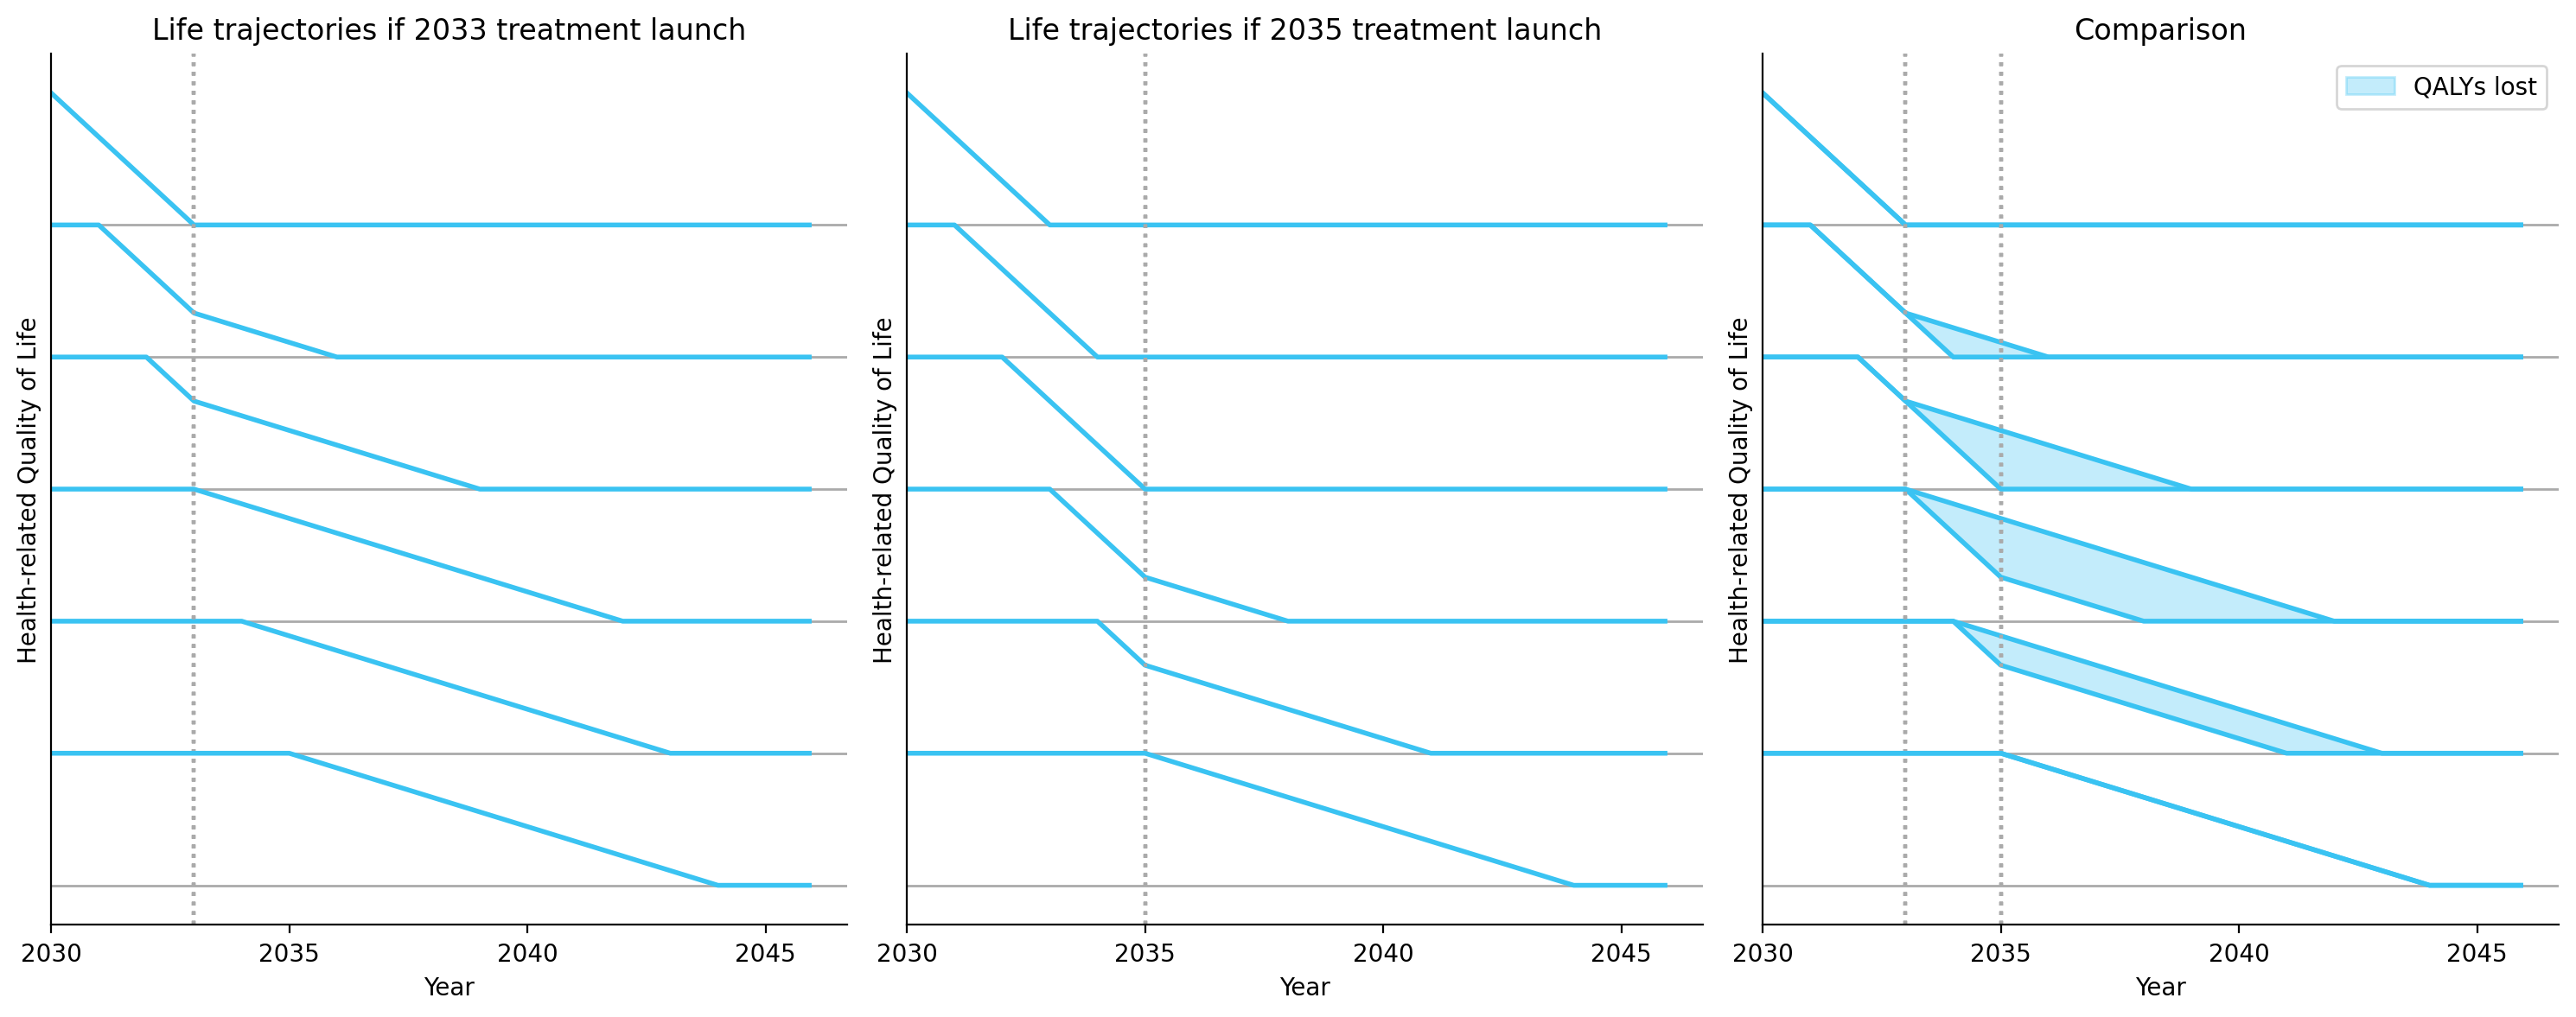

In [19]:
sim1 = Simulation(pre_cure_disease_duration=3*12, post_cure_disease_duration=9*12, cure_onset=3*12, num_persons=6, onset_freq='Y')
sim1.run()
sim2 = Simulation(pre_cure_disease_duration=3*12, post_cure_disease_duration=9*12, cure_onset=5*12, num_persons=6, onset_freq='Y')
sim2.run()
fig, axes = plt.subplots(1, 3, figsize=[15, 6])
plt.sca(axes[0]); plot_sim(sim1); plt.title('Life trajectories if 2033 treatment launch')
plt.sca(axes[1]); plot_sim(sim2); plt.title('Life trajectories if 2035 treatment launch')
plt.sca(axes[2]); plot_sim_comparison(sim1, sim2); plt.title('Comparison')
plt.tight_layout()
compute_qalys_lost(sim1, sim2)


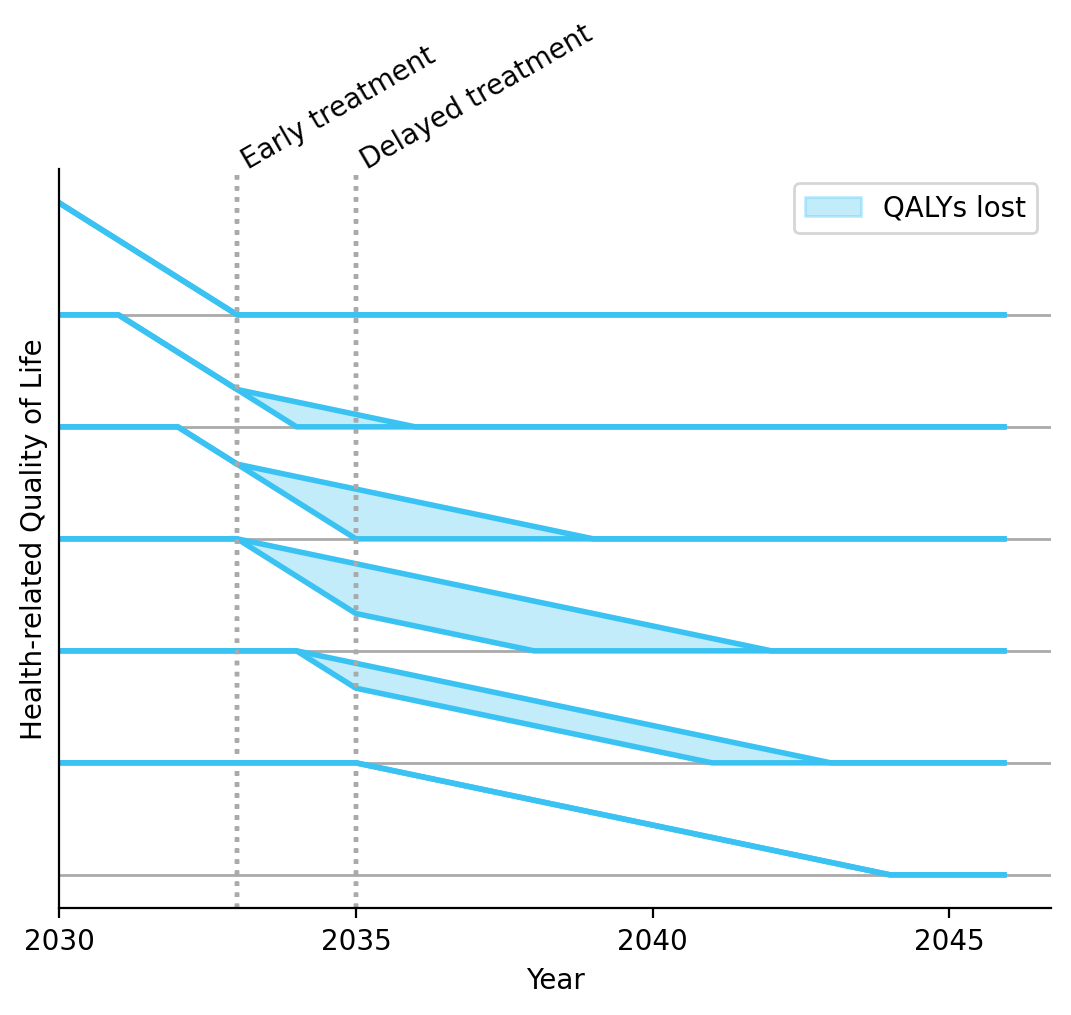

In [10]:
plot_sim_comparison(sim1, sim2, show_annotation=True)

# Alzheimer's disease
Assumptions:
* [50 million people worldwide have it](https://www.who.int/news-room/fact-sheets/detail/dementia)
* In the absence of new treatments, this value is held constant by a constant stream of disease onsets and deaths. 
* Quality of life declines linearly over 10 years from disease onset (quality=1) to death (quality=0)
* The treatment reduces the slope by a factor of 2.
* We compare treatment onset in the year 2033 to 2044.

Average QALYs lost per affected person: 0.7275896990740741 

Total QALYs lost: 36379484.95370371 



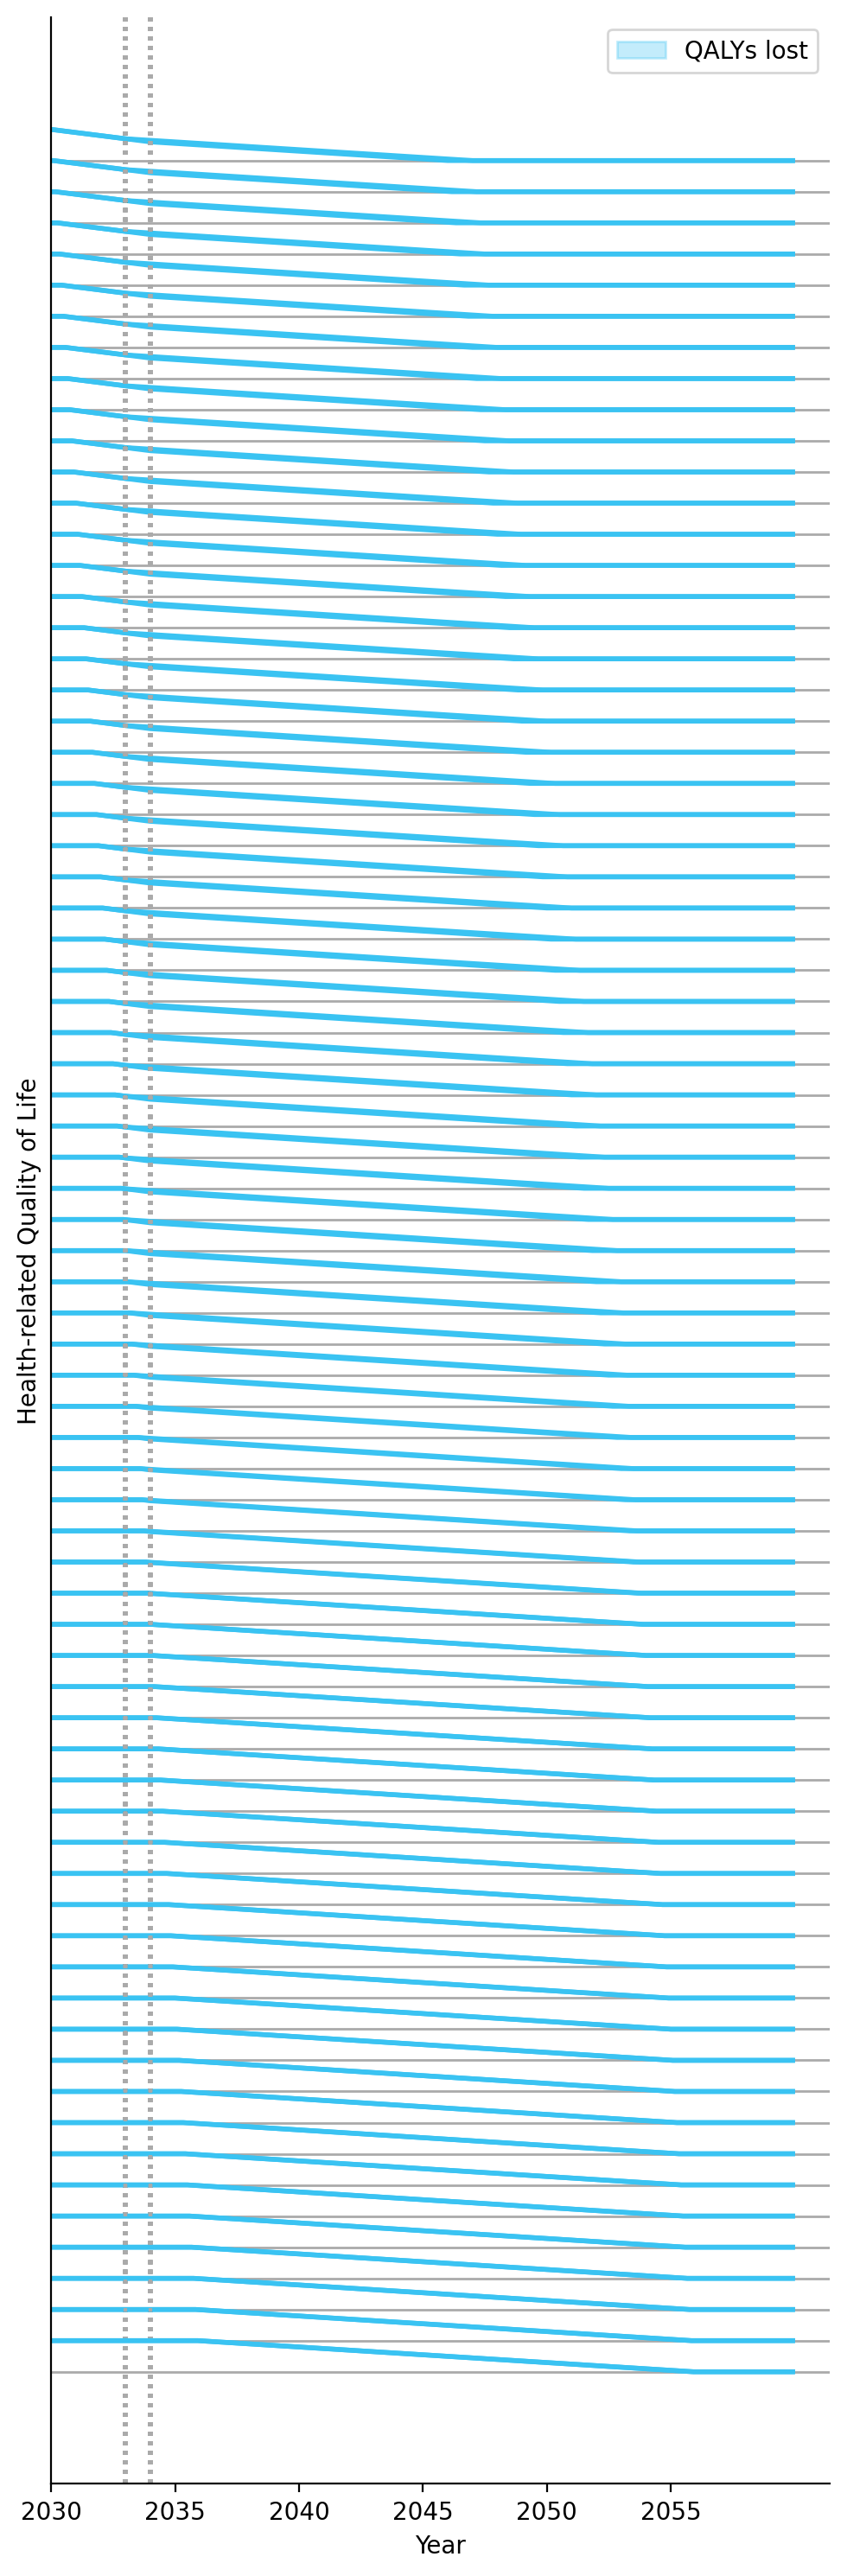

In [12]:
sim1 = Simulation(pre_cure_disease_duration=10*12, post_cure_disease_duration=20*12, cure_onset=3*12, num_persons=6*12, onset_freq='M', max_year=2060)
sim1.run()
sim2 = Simulation(pre_cure_disease_duration=10*12, post_cure_disease_duration=20*12, cure_onset=4*12, num_persons=6*12, onset_freq='M', max_year=2060)
sim2.run()
plt.figure(figsize=[5, 15])
plot_sim_comparison(sim1, sim2)
plt.tight_layout()
compute_qalys_lost(sim1, sim2, 50_000_000)

# Cancer
Assumptions:
* [20 million people worldwide have it](https://www.wcrf.org/cancer-trends/worldwide-cancer-data)
* In the absence of new treatments, this value is held constant by a constant stream of disease onsets and deaths. 
* Quality of life declines linearly over 3 years from disease onset (quality=1) to death (quality=0)
* The treatment reduces the slope by a factor of 3.
* We compare treatment onset in the year 2033 to 2044.


Average QALYs lost per affected person: 0.7659574468085107 

Total QALYs lost: 15319148.936170215 



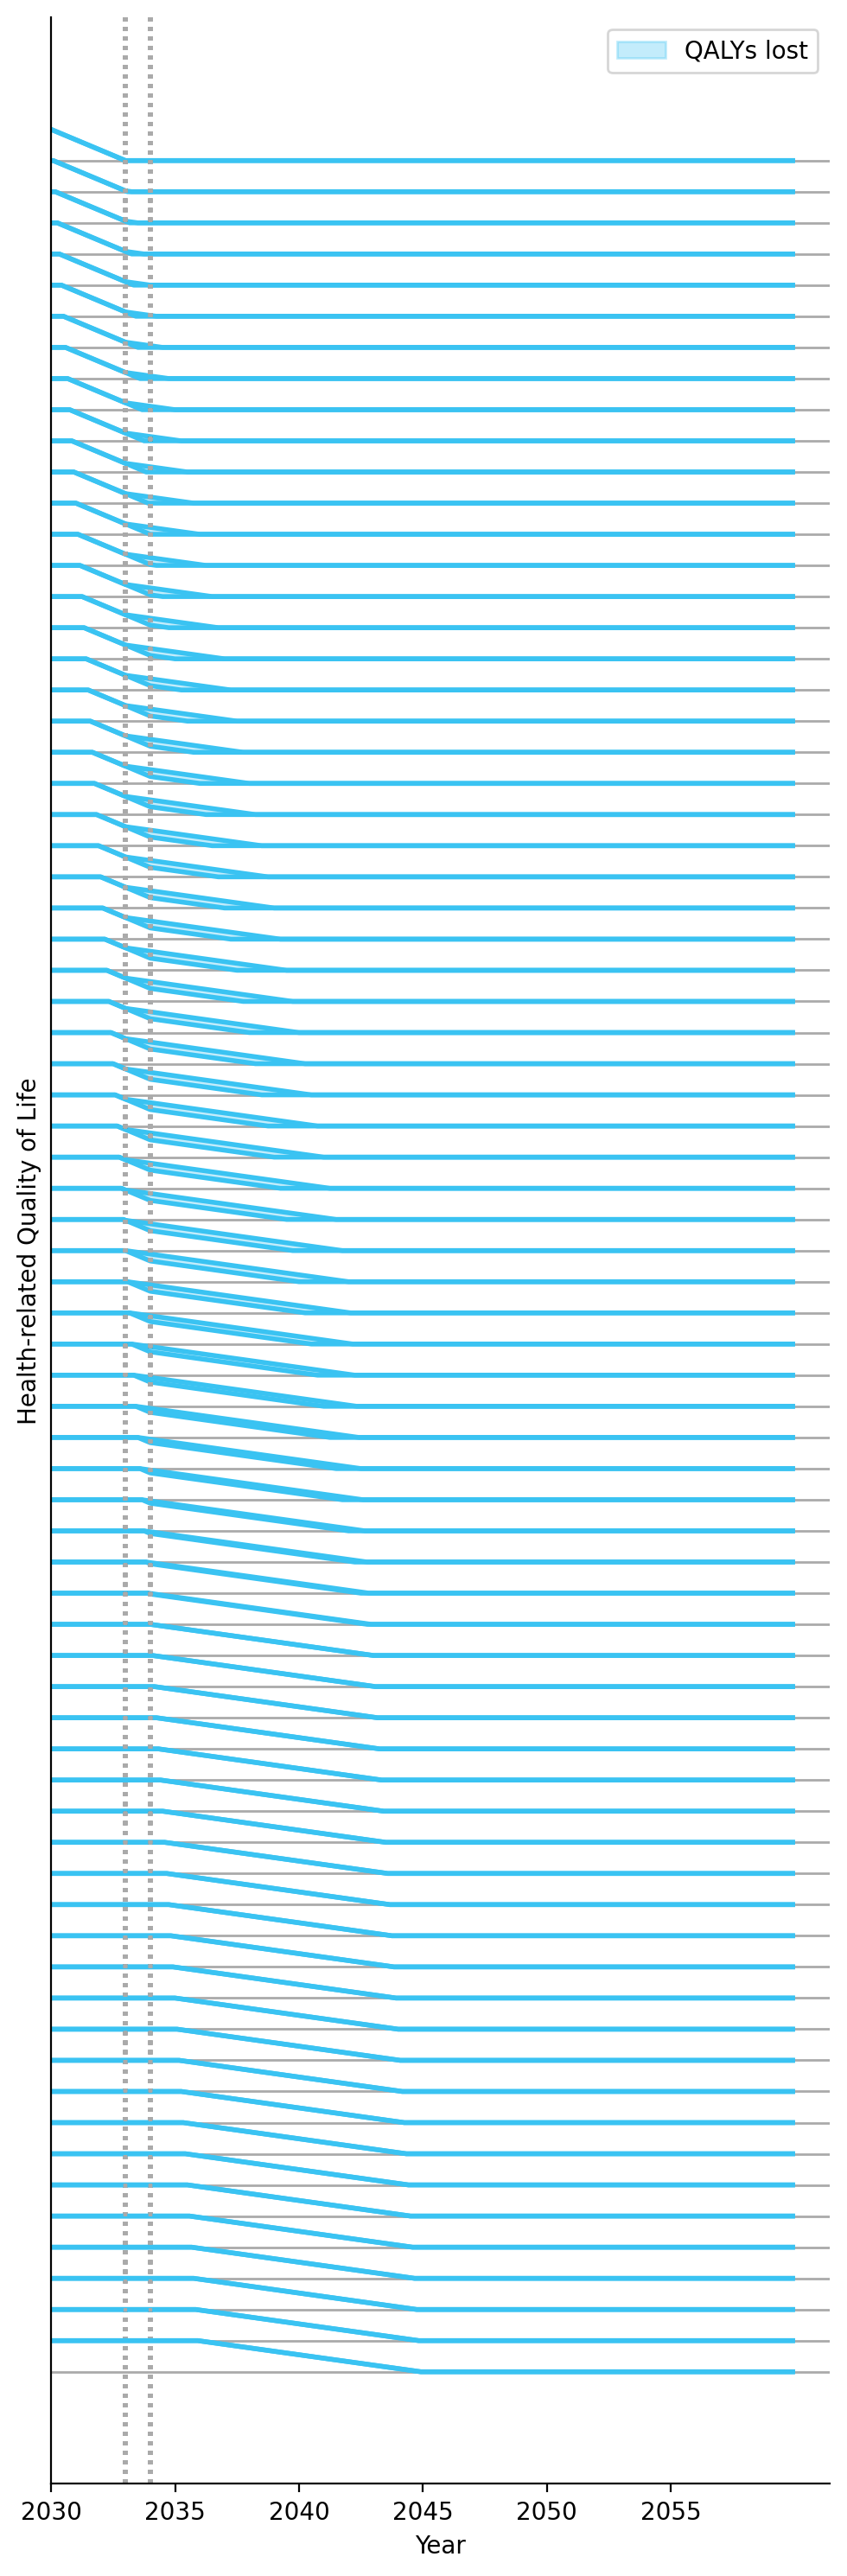

In [13]:
sim1 = Simulation(pre_cure_disease_duration=3*12, post_cure_disease_duration=9*12, cure_onset=3*12, num_persons=6*12, onset_freq='M', max_year=2060)
sim1.run()
sim2 = Simulation(pre_cure_disease_duration=3*12, post_cure_disease_duration=9*12, cure_onset=4*12, num_persons=6*12, onset_freq='M', max_year=2060)
sim2.run()
plt.figure(figsize=[5, 15])
plot_sim_comparison(sim1, sim2)
plt.tight_layout()
compute_qalys_lost(sim1, sim2, 20_000_000)